In [13]:
import pandas as pd
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import monotonically_increasing_id, udf
from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")

import schemas
import tools

In [2]:
def load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def load_parquet_from_weather_toPandas(path, schema:StructType = None):
    """
    load apache parquet file
    """
    weather = load_parquet(path) \
                    .withColumnRenamed("__index_level_0__", "TIME") \
                    .dropna() \
                    .withColumn("id", monotonically_increasing_id())
    weather.createOrReplaceTempView("weather_temp")
    weather_dic = spark.sql("select * from weather_temp where id in (select max(id) as id from weather_temp group by TIME)").toPandas()
    return weather_dic

def load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    # return sqlContext.read.schema(schema).csv(path, sep=";", header=True, schema=schema) if schema is not None else sqlContext.read.schema(schema).csv(path, sep=";", header=True)
    return sqlContext.read.csv(path, sep=";", header=True, schema=schema)


In [3]:
def udf_by_grid(df:pd.DataFrame, type = DoubleType()):
    return udf(lambda g, t: list(df[df['TIME'] == t][g])[0], type)
def udf_by_ws():
    schema = StructType([
        StructField("u_interp", DoubleType(), True),
        StructField("v_interp", DoubleType(), True)
    ])
    return udf(lambda s1, d1, s2, d2, z: tools.wind_interp(s1, d1, s2, d2, z), schema)

In [4]:
def udf_regist():
    udf_ws10  = udf_by_grid(ws10_dic, DoubleType())
    udf_ws100  = udf_by_grid(ws100_dic, DoubleType())
    udf_wd10  = udf_by_grid(wd10_dic, IntegerType())
    udf_wd100  = udf_by_grid(wd100_dic, IntegerType())
    udf_ws_interp  = udf_by_ws()
    return udf_ws10, udf_ws100, udf_wd10, udf_wd100, udf_ws_interp

In [5]:
# initialise sparkContext\
spark = SparkSession.builder \
    .master("local") \
    .appName("WindTurbine") \
    .config("spark.executor.memory", "8gb") \
    .config("spark.cores.max", "4") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

In [6]:
 # to read parquet file
settlement = load_parquet("data/ITU_DATA/settlement/2019.parquet", schemas.settlement_schema)
settlement = settlement.dropna(subset =["VAERDI"]) \
            .withColumn("VAERDI", settlement["VAERDI"].cast("double")) \
            .where("TIME_CET like '%:00:%'") \

settlement_last = settlement.where("TIME_CET like '2019-12-30%'") \

# settlement = settlement.where("TIME_CET not like '2019-12-30%'").sample(fraction=0.00001, seed=5)
settlement = settlement.sample(fraction=0.00001, seed=5)

In [ ]:
settlement.printSchema()

In [7]:
windmills = load_csv("data/windmill_cleaned.csv", schemas.windmills_schema) \
            .dropna(subset =["Capacity_kw", "Rotor_diameter", "Navhub_height"]) \
            .where("grid != 0") \
            .where("Navhub_height != 0")

In [ ]:
windmills.printSchema()

In [8]:
ws10_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_10m.parquet")
ws100_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_100m.parquet")
wd10_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_10m.parquet")
wd100_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_100m.parquet")

In [9]:
udf_ws10, udf_ws100, udf_wd10, udf_wd100, udf_ws_interp = udf_regist()

In [10]:
def aggregate(df):
    df = df.join(windmills, on="GSRN") \
                    .select("GSRN", "TIME_CET", "Capacity_kw", "Rotor_diameter", "Navhub_height", "VAERDI", "grid")

    df = df.withColumn("ws10", udf_ws10(df.grid, df.TIME_CET)) \
            .withColumn("ws100", udf_ws100(df.grid, df.TIME_CET)) \
            .withColumn("wd10", udf_wd10(df.grid, df.TIME_CET)) \
            .withColumn("wd100", udf_wd100(df.grid, df.TIME_CET))

    df = df.withColumn("wsCol", \
                udf_ws_interp(df.ws10, df.wd10, df.ws100, df.wd100, df.Navhub_height)) \
                .select("GSRN", "TIME_CET", "Capacity_kw", "Rotor_diameter", "Navhub_height", "VAERDI", "wsCol.u_interp", "wsCol.v_interp")
    return df

In [11]:
train = aggregate(settlement)
test = aggregate(settlement_last)

In [16]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [17]:
feat_cols = ["Capacity_kw", "Rotor_diameter", "Navhub_height", "u_interp", "v_interp"]
vec_assembler = VectorAssembler(inputCols=feat_cols, outputCol="features")
train_feat = vec_assembler.transform(train).select("TIME_CET", "features", "VAERDI")

test_feat = vec_assembler.transform(test).select("TIME_CET", "features", "VAERDI")

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(train_feat)
train_scaled = scalerModel.transform(train_feat)

scalerModel = scaler.fit(test_feat)
test_scaled = scalerModel.transform(test_feat)

In [ ]:
test_feat.show(5)

In [18]:
kmean = KMeans(featuresCol='features', k=60)

In [19]:
model = kmean.fit(train_feat)
pred_agged = model.transform(train_feat).groupBy("prediction").avg("VAERDI").select("prediction", "avg(VAERDI)")
pred_tested = model.transform(test_feat).select("TIME_CET","prediction", "VAERDI")

In [ ]:
pred_agged.show(5)

In [20]:
import pyspark.sql.functions as sf
result = pred_agged.join(pred_tested, on="prediction") \
        .groupby("TIME_CET") \
        .agg(sf.sum("avg(VAERDI)").alias("predicted"), sf.sum("VAERDI").alias("truth")) \
        .orderBy("TIME_CET") \
        .select("TIME_CET","predicted","truth")

In [ ]:
result.show(50)

In [21]:
data = result.toPandas()

In [22]:
import seaborn as sns

In [24]:
data.head()

,TIME_CET,predicted,truth
0,2019-12-30 00:00:00,533172.602641,942420.326
1,2019-12-30 01:00:00,533012.804291,1005618.008
2,2019-12-30 02:00:00,529989.064737,970211.891
3,2019-12-30 03:00:00,529924.778429,954106.274
4,2019-12-30 04:00:00,530500.014685,1022127.096


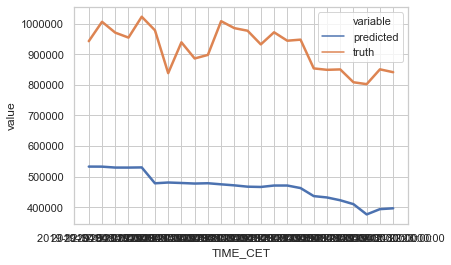

In [26]:
sns.set(style="whitegrid")
sns.lineplot(x="TIME_CET", y="value", data=pd.melt(data, ['TIME_CET']), hue='variable',linewidth=2.5)